# Working With Time Series Data with Apache Spark

Have you ever wondered how to analyse Time Series data at scale? How can we do Time Series analysis on Terrabytes of data. Do you want to convert your pandas based Time Series processing and take it to scale using Spark? Would it have been better if you had several working end-to-end examples to refer at one place? Then Read On...

## Why we use Apache Spark for Time Series Analysis?

Time Series by definition is fundamentally an ordered sequence of observations or measurement of a particular variable, event etc. and the measurements are taken at fixed time intervals. Since, its ordered parallelizing computations is a bit tricky and sometimes not possible as well. I have been working with Time Series data in my day to day job. Like any other Data Science person I started with Pandas DataFrame which created the foundation for me. But I had to analyse Hourly metric readings from Storage Devices and our data size was in TBs. I could only analyze 4 or 5 systems on my machine. Eventually, I had to learn Spark for Big Data processing.

I could not put up our own data due to customer privacy. However, I neeed to do Rasampling, Missing Values Replacements, Rolling Averages, User Sessionization, Stock Market Financial Data Analyis, Click Stream Analysis etc. While we could have used [flint](https://github.com/twosigma/flint) from [Two Sigma](https://www.twosigma.com/) but since it is not integaretd with Spark yet so I could not use it due to corporate issues. Also, there is another Spark Time Series processing framework [spark-ts](https://github.com/sryza/spark-timeseries) is not under active development now, and the last commit was in May, 2017 so I did not use it either. I relied on default Spark and see what best we can achieve and learn as much as I can.

We will be extensivley using the anaytics functions in this notebook specially the `Window`, `Over`, `Row_Number`, `Rank`, `Dense_Rank`, `Lag`, `Lead` etc. functions. https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html#module-pyspark.sql.functions

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.window import Window

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)

plt.style.use('seaborn-whitegrid')

#sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
#rcParams['figure.figsize'] = 18,4

In [4]:
# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

In [6]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

### Creating the Spark Session:

In [7]:
# The following must be set in your .bashrc file
#SPARK_HOME="/home/ubuntu/spark-2.4.0-bin-hadoop2.7"
#ANACONDA_HOME="/home/ubuntu/anaconda3/envs/pyspark"
#PYSPARK_PYTHON="$ANACONDA_HOME/bin/python"
#PYSPARK_DRIVER_PYTHON="$ANACONDA_HOME/bin/python"
#PYTHONPATH="$ANACONDA_HOME/bin/python"
#export PATH="$ANACONDA_HOME/bin:$SPARK_HOME/bin:$PATH"

In [8]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("working-with-time-series-data")
         .getOrCreate())

In [9]:
spark

In [10]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=working-with-time-series-data>

## 1. Resampling Data:

## 1.1. Household Electrical Consumption Data:

In [11]:
ELECTRIC_POWER_CONSUMPTION = 'data/household-electric-power-consumption/consumption.txt'

In [12]:
pow_consump_df = spark.read.csv(path=ELECTRIC_POWER_CONSUMPTION, sep=';', header=True, inferSchema=True)

In [13]:
pow_consump_df.count()

2075259

In [14]:
pow_consump_df.sample(withReplacement=False, fraction=0.000005, seed=rnd_seed).toPandas()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,14/1/2007,16:59:00,2.376,0.000,239.680,10.800,26.000,0.000,0.0
1,15/5/2007,05:24:00,0.268,0.050,237.200,1.200,0.000,0.000,0.0
2,3/8/2007,22:54:00,0.140,0.000,237.040,0.600,0.000,0.000,0.0
3,15/10/2007,23:42:00,0.330,0.054,242.510,1.400,0.000,0.000,0.0
4,14/6/2008,12:48:00,1.446,0.246,242.290,6.000,0.000,1.000,18.0
5,25/6/2008,10:44:00,0.242,0.000,236.900,1.200,0.000,0.000,0.0
6,19/1/2010,09:13:00,3.596,0.000,240.370,14.800,39.000,0.000,18.0
7,8/10/2010,06:07:00,0.500,0.280,239.130,2.400,0.000,2.000,0.0


In [15]:
pow_consump_df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Global_active_power: string (nullable = true)
 |-- Global_reactive_power: string (nullable = true)
 |-- Voltage: string (nullable = true)
 |-- Global_intensity: string (nullable = true)
 |-- Sub_metering_1: string (nullable = true)
 |-- Sub_metering_2: string (nullable = true)
 |-- Sub_metering_3: double (nullable = true)



We can see Spark was not able to identify the schema of Date and Time

In [16]:
# convert order_date into date format
pow_consump_df = pow_consump_df.withColumn('Date_Time', F.concat_ws(' ', 'Date', 'Time'))
pow_consump_df = pow_consump_df.withColumn('Date_Time', F.to_timestamp(col('Date_Time'), format='dd/MM/yyyy HH:mm:ss')).cache()
pow_consump_df.cache()

DataFrame[Date: string, Time: string, Global_active_power: string, Global_reactive_power: string, Voltage: string, Global_intensity: string, Sub_metering_1: string, Sub_metering_2: string, Sub_metering_3: double, Date_Time: timestamp]

In [17]:
pow_consump_df = (pow_consump_df
 .select('Date_Time', 
         F.dayofmonth('Date_Time').alias('Day'),
         F.month('Date_Time').alias('Month'), 
         F.year('Date_Time').alias('Year'), 
         F.hour('Date_Time').alias('Hour'), 
         F.weekofyear('Date_Time').alias('Week'),
         col('Global_active_power').cast(DoubleType()))
 .filter(col('Year').isin([2008, 2009])))
pow_consump_df.cache()

DataFrame[Date_Time: timestamp, Day: int, Month: int, Year: int, Hour: int, Week: int, Global_active_power: double]

In [18]:
pow_consump_df.show(10)

+-------------------+---+-----+----+----+----+-------------------+
|          Date_Time|Day|Month|Year|Hour|Week|Global_active_power|
+-------------------+---+-----+----+----+----+-------------------+
|2008-01-01 00:00:00|  1|    1|2008|   0|   1|               1.62|
|2008-01-01 00:01:00|  1|    1|2008|   0|   1|              1.626|
|2008-01-01 00:02:00|  1|    1|2008|   0|   1|              1.622|
|2008-01-01 00:03:00|  1|    1|2008|   0|   1|              1.612|
|2008-01-01 00:04:00|  1|    1|2008|   0|   1|              1.612|
|2008-01-01 00:05:00|  1|    1|2008|   0|   1|              1.546|
|2008-01-01 00:06:00|  1|    1|2008|   0|   1|              1.544|
|2008-01-01 00:07:00|  1|    1|2008|   0|   1|               1.55|
|2008-01-01 00:08:00|  1|    1|2008|   0|   1|              1.548|
|2008-01-01 00:09:00|  1|    1|2008|   0|   1|              1.548|
+-------------------+---+-----+----+----+----+-------------------+
only showing top 10 rows



In [19]:
pow_consump_df.printSchema()

root
 |-- Date_Time: timestamp (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Global_active_power: double (nullable = true)



In [20]:
pow_consump_df.createOrReplaceTempView('pow_consump')

In [21]:
pdf = pow_consump_df.select('Hour', 'Month', 'Year', 'Global_active_power').sample(withReplacement=False, fraction=0.1, seed=rnd_seed).toPandas()

In [22]:
pdf.head()

,Hour,Month,Year,Global_active_power
0,0,1,2008,1.536
1,0,1,2008,1.646
2,0,1,2008,1.568
3,0,1,2008,1.568
4,1,1,2008,1.544


### 1.1.1. Hourly Distribution:

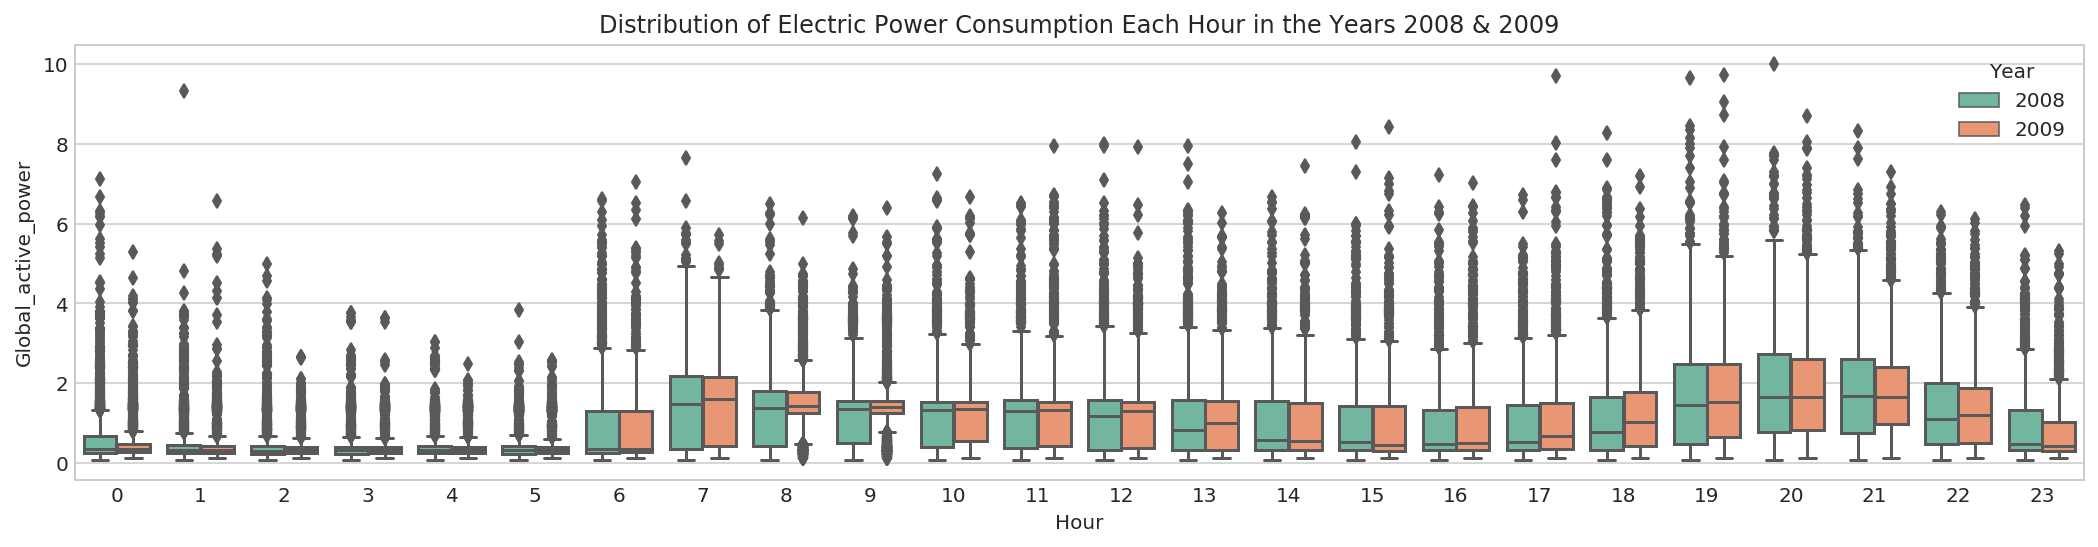

In [23]:
g = sns.boxplot(x='Hour', y='Global_active_power', hue='Year', data=pdf, palette='Set2')
g.set_title('Distribution of Electric Power Consumption Each Hour in the Years 2008 & 2009');

### 1.1.2. Monthly Distribution:

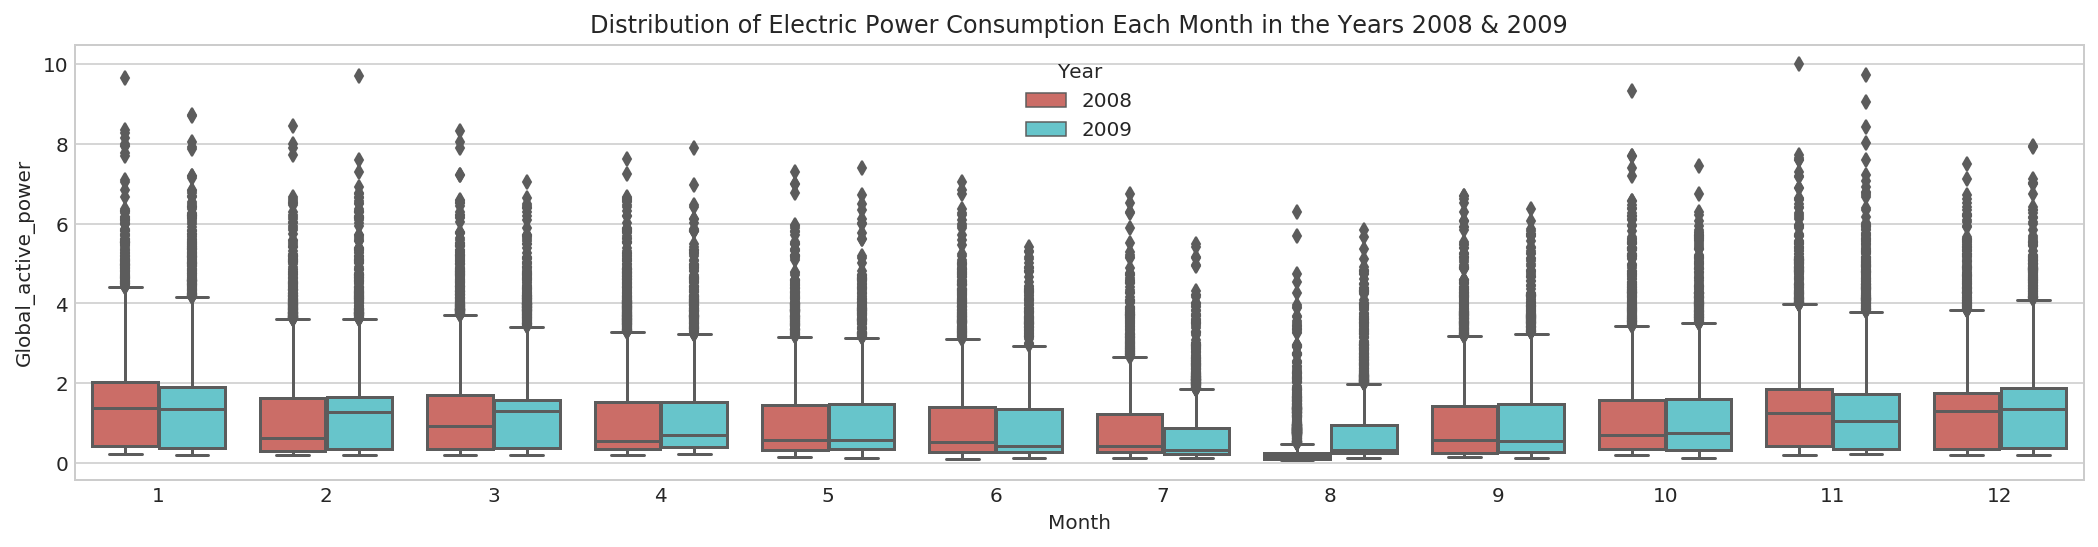

In [24]:
g = sns.boxplot(x='Month', y='Global_active_power', hue='Year', data=pdf, palette='hls')
g.set_title('Distribution of Electric Power Consumption Each Month in the Years 2008 & 2009');

### 1.1.3. Yearly Distribution:

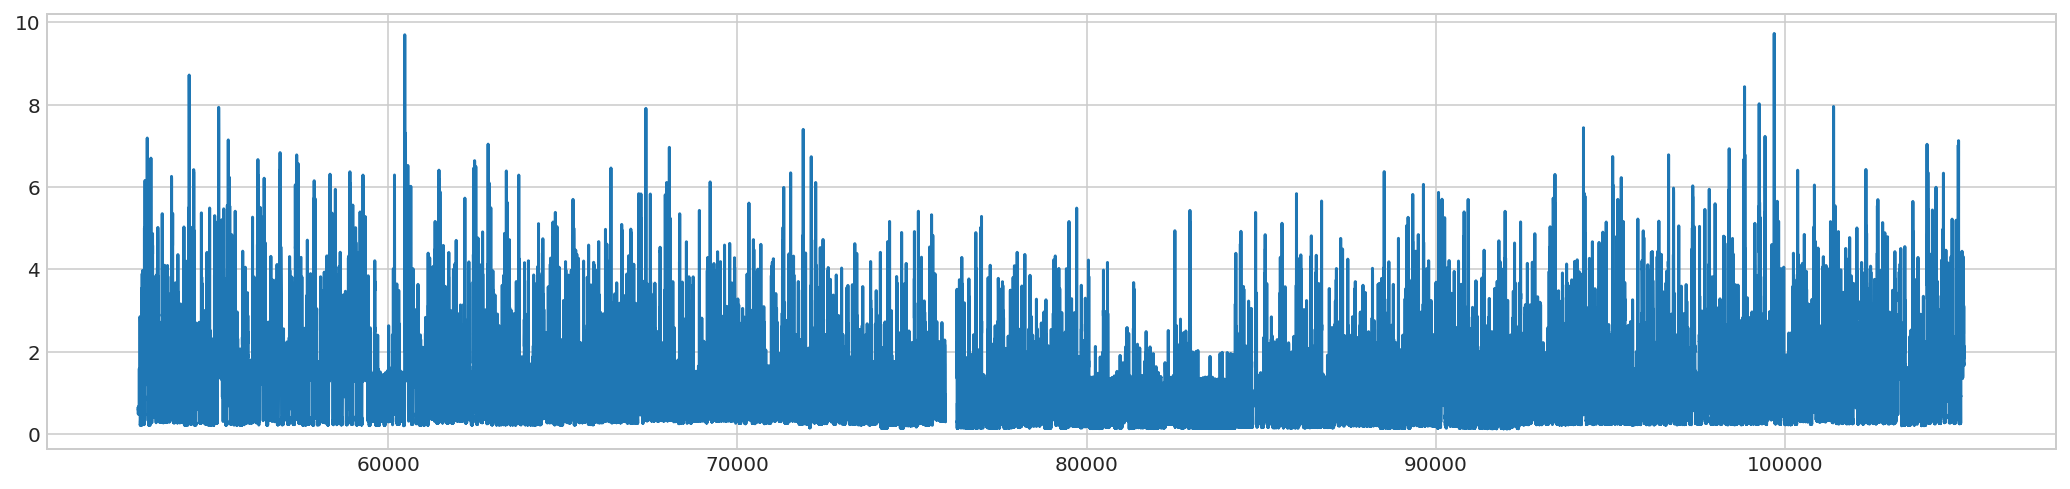

In [25]:
plt.plot(pdf[pdf['Year'] == 2009]['Global_active_power']);

In [26]:
spark.sql('select * from pow_consump').show(10)

+-------------------+---+-----+----+----+----+-------------------+
|          Date_Time|Day|Month|Year|Hour|Week|Global_active_power|
+-------------------+---+-----+----+----+----+-------------------+
|2008-01-01 00:00:00|  1|    1|2008|   0|   1|               1.62|
|2008-01-01 00:01:00|  1|    1|2008|   0|   1|              1.626|
|2008-01-01 00:02:00|  1|    1|2008|   0|   1|              1.622|
|2008-01-01 00:03:00|  1|    1|2008|   0|   1|              1.612|
|2008-01-01 00:04:00|  1|    1|2008|   0|   1|              1.612|
|2008-01-01 00:05:00|  1|    1|2008|   0|   1|              1.546|
|2008-01-01 00:06:00|  1|    1|2008|   0|   1|              1.544|
|2008-01-01 00:07:00|  1|    1|2008|   0|   1|               1.55|
|2008-01-01 00:08:00|  1|    1|2008|   0|   1|              1.548|
|2008-01-01 00:09:00|  1|    1|2008|   0|   1|              1.548|
+-------------------+---+-----+----+----+----+-------------------+
only showing top 10 rows



In [27]:
spark.sql('select * from pow_consump where Month = 7 and Year = 2009').show(10)

+-------------------+---+-----+----+----+----+-------------------+
|          Date_Time|Day|Month|Year|Hour|Week|Global_active_power|
+-------------------+---+-----+----+----+----+-------------------+
|2009-07-01 00:00:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:01:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:02:00|  1|    7|2009|   0|  27|              0.196|
|2009-07-01 00:03:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:04:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:05:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:06:00|  1|    7|2009|   0|  27|              0.258|
|2009-07-01 00:07:00|  1|    7|2009|   0|  27|              0.272|
|2009-07-01 00:08:00|  1|    7|2009|   0|  27|              0.272|
|2009-07-01 00:09:00|  1|    7|2009|   0|  27|              0.272|
+-------------------+---+-----+----+----+----+-------------------+
only showing top 10 rows



In [28]:
spark.sql('select * from pow_consump where Month = 7 and Year = 2009 and Day = 31').count()

1440

In [29]:
60*24

1440

In [30]:
spark.sql('select * from pow_consump where Month = 7 and Year = 2009').count()

44640

In [31]:
31 * 24 * 60 # 31 days x 24 ours x 60 minutes

44640

### 1.1.4. Resample Monthly:

In [32]:
# Monthly resample
monthly_resampled = spark.sql(
"""
select to_date(concat_ws('-', lpad(Month, 2, '0'), '01', Year), 'MM-dd-yyyy') as resampled_month, 
Month, Year,
ROUND(AVG(Global_active_power), 2) as avg_consumption, 
ROUND(MAX(Global_active_power), 2) as max_consumption, 
ROUND(MIN(Global_active_power), 2) as min_consumption 
FROM pow_consump 
WHERE Year in (2009)
GROUP BY month, year 
ORDER BY month, year
""")

monthly_resampled.cache()

DataFrame[resampled_month: date, Month: int, Year: int, avg_consumption: double, max_consumption: double, min_consumption: double]

In [33]:
monthly_resampled.show(12)

+---------------+-----+----+---------------+---------------+---------------+
|resampled_month|Month|Year|avg_consumption|max_consumption|min_consumption|
+---------------+-----+----+---------------+---------------+---------------+
|     2009-01-01|    1|2009|           1.41|           9.59|            0.2|
|     2009-02-01|    2|2009|           1.25|          11.12|            0.2|
|     2009-03-01|    3|2009|           1.23|           8.31|            0.2|
|     2009-04-01|    4|2009|           1.14|           7.97|           0.21|
|     2009-05-01|    5|2009|           1.01|           7.86|           0.14|
|     2009-06-01|    6|2009|           0.84|           8.76|           0.13|
|     2009-07-01|    7|2009|           0.62|           5.93|           0.12|
|     2009-08-01|    8|2009|           0.66|            7.7|           0.13|
|     2009-09-01|    9|2009|           0.99|           7.83|           0.12|
|     2009-10-01|   10|2009|           1.14|           8.71|           0.12|

In [34]:
pdf = monthly_resampled.select('resampled_month', 'avg_consumption').toPandas()

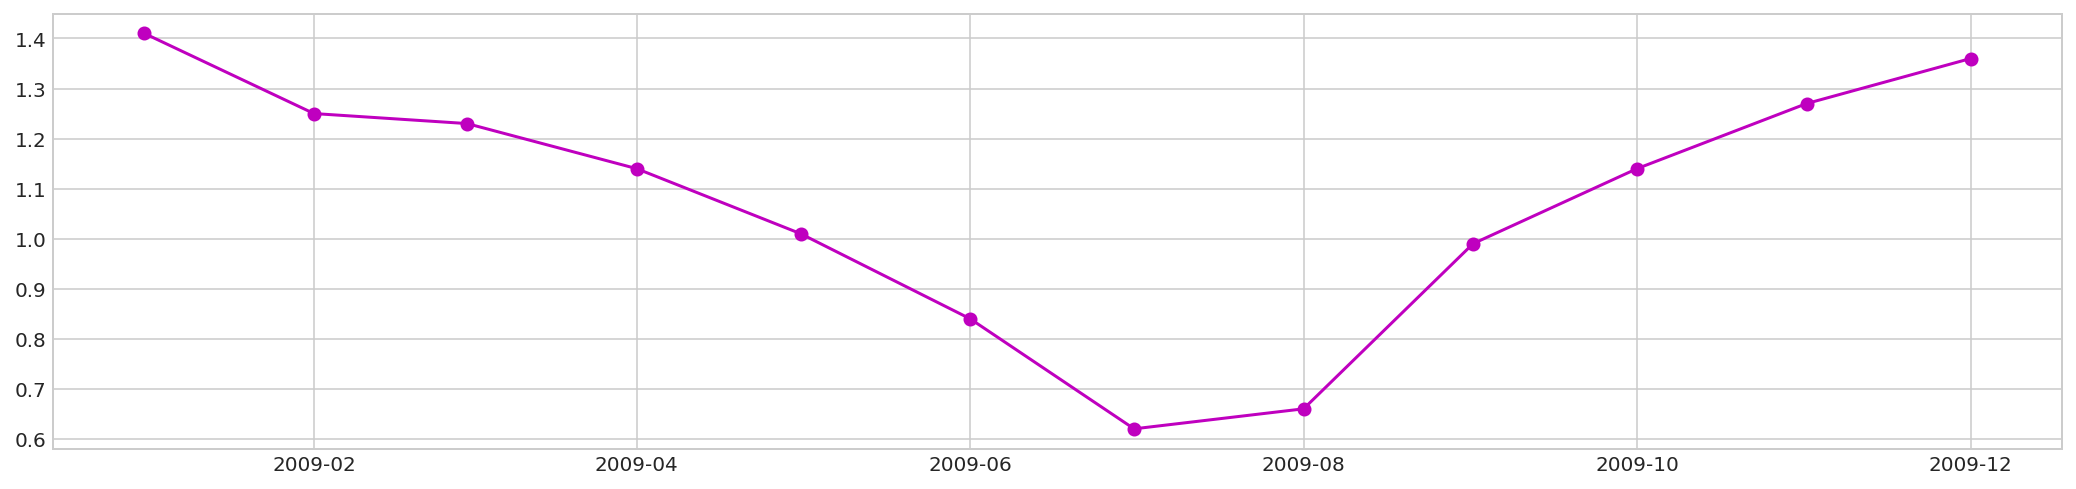

In [35]:
plt.plot_date(pdf['resampled_month'], pdf['avg_consumption'], linestyle='-', color='m');

### 1.1.5. Resample Daily:

In [36]:
# Daily resample
daily_resampled_df = spark.sql(
"""
select to_date(concat_ws('-', lpad(Month, 2, '0'), lpad(Day, 2, '0'), Year), 'MM-dd-yyyy') as resampled_day, 
Day, Month, Year,
ROUND(AVG(Global_active_power), 2) as avg_consumption, 
ROUND(MAX(Global_active_power), 2) max_consumption, 
ROUND(MIN(Global_active_power), 2) min_consumption 
FROM pow_consump 
WHERE Year in (2008, 2009) 
GROUP BY day, month, year 
ORDER BY day, month, year
""")
daily_resampled_df.cache()

DataFrame[resampled_day: date, Day: int, Month: int, Year: int, avg_consumption: double, max_consumption: double, min_consumption: double]

In [37]:
daily_resampled_df.createOrReplaceTempView('daily_resampled')

In [38]:
daily_resampled_df.show(10)

+-------------+---+-----+----+---------------+---------------+---------------+
|resampled_day|Day|Month|Year|avg_consumption|max_consumption|min_consumption|
+-------------+---+-----+----+---------------+---------------+---------------+
|   2008-01-01|  1|    1|2008|           1.92|           5.69|           0.23|
|   2009-01-01|  1|    1|2009|           0.98|           8.58|            0.2|
|   2008-02-01|  1|    2|2008|           1.07|           6.56|           0.21|
|   2009-02-01|  1|    2|2009|           1.29|           6.56|           0.21|
|   2008-03-01|  1|    3|2008|           0.79|           4.04|           0.48|
|   2009-03-01|  1|    3|2009|           1.71|           6.71|           0.26|
|   2008-04-01|  1|    4|2008|           1.48|           6.32|           0.23|
|   2009-04-01|  1|    4|2009|           1.14|           4.23|           0.21|
|   2008-05-01|  1|    5|2008|            0.4|            1.5|           0.24|
|   2009-05-01|  1|    5|2009|           1.05|      

In [39]:
daily_resampled_df.printSchema()

root
 |-- resampled_day: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- avg_consumption: double (nullable = true)
 |-- max_consumption: double (nullable = true)
 |-- min_consumption: double (nullable = true)



In [40]:
pdf = daily_resampled_df.toPandas()

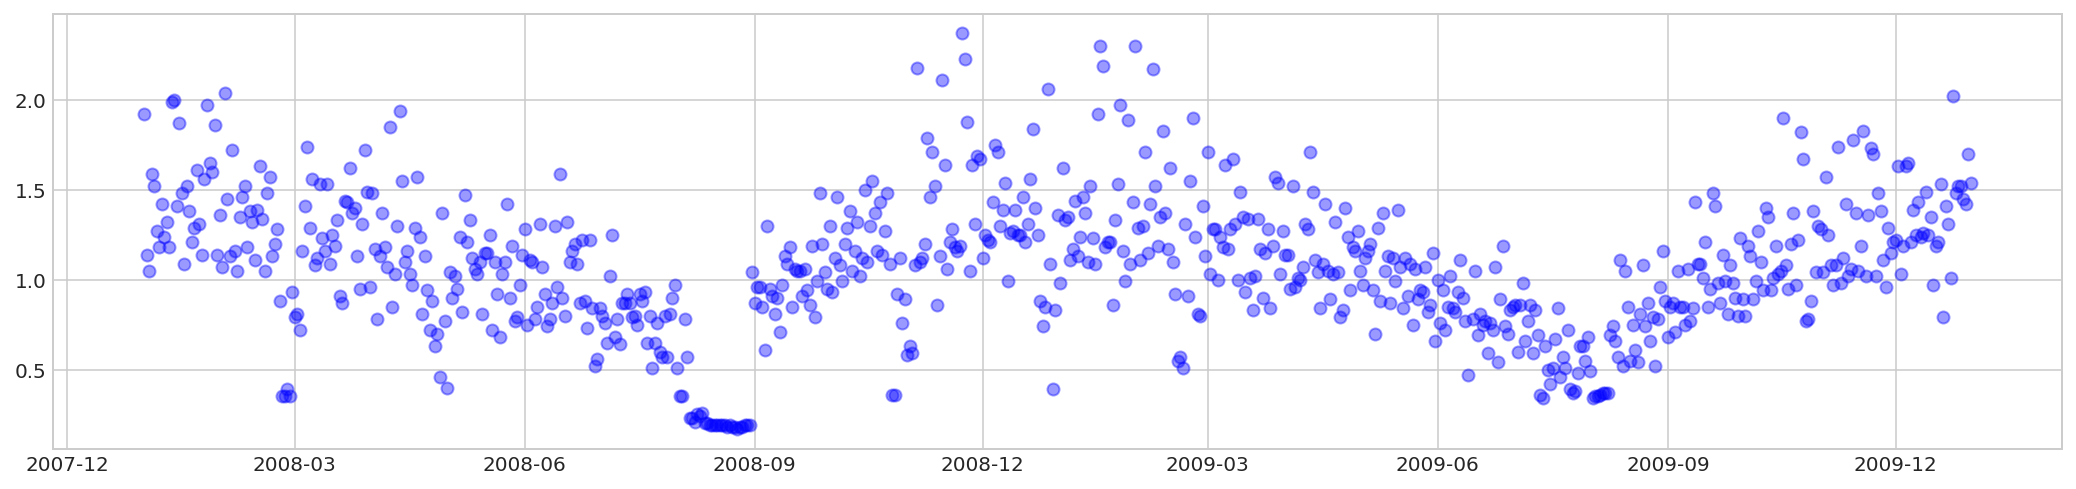

In [41]:
plt.plot_date(pdf['resampled_day'], pdf['avg_consumption'], color='b', alpha=0.4);

## 2. Rolling Means & Standard Deviations:

### 2.1. 7 Days Moving Average:

In [42]:
daily_resampled_df.printSchema()

root
 |-- resampled_day: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- avg_consumption: double (nullable = true)
 |-- max_consumption: double (nullable = true)
 |-- min_consumption: double (nullable = true)



In [43]:
daily_resampled_df = spark.sql(
"""
SELECT resampled_day, Day, Month, Year, avg_consumption, 
ROUND(AVG(avg_consumption) OVER (PARTITION BY Year, Month ORDER BY Day ROWS BETWEEN 7 PRECEDING AND CURRENT ROW), 2) AS moving_avg,
ROUND(stddev(avg_consumption) OVER (PARTITION BY Year, Month ORDER BY Day ROWS BETWEEN 7 PRECEDING AND CURRENT ROW), 2) AS std_dev
FROM daily_resampled
ORDER BY Year, Month, Day
""")

daily_resampled_df.cache()

DataFrame[resampled_day: date, Day: int, Month: int, Year: int, avg_consumption: double, moving_avg: double, std_dev: double]

In [44]:
daily_resampled_df

DataFrame[resampled_day: date, Day: int, Month: int, Year: int, avg_consumption: double, moving_avg: double, std_dev: double]

In [45]:
daily_resampled_df.show(10)

+-------------+---+-----+----+---------------+----------+-------+
|resampled_day|Day|Month|Year|avg_consumption|moving_avg|std_dev|
+-------------+---+-----+----+---------------+----------+-------+
|   2008-01-01|  1|    1|2008|           1.92|      1.92|    NaN|
|   2008-01-02|  2|    1|2008|           1.14|      1.53|   0.55|
|   2008-01-03|  3|    1|2008|           1.05|      1.37|   0.48|
|   2008-01-04|  4|    1|2008|           1.59|      1.42|   0.41|
|   2008-01-05|  5|    1|2008|           1.52|      1.44|   0.35|
|   2008-01-06|  6|    1|2008|           1.27|      1.41|   0.32|
|   2008-01-07|  7|    1|2008|           1.18|      1.38|   0.31|
|   2008-01-08|  8|    1|2008|           1.42|      1.39|   0.29|
|   2008-01-09|  9|    1|2008|           1.24|       1.3|   0.19|
|   2008-01-10| 10|    1|2008|           1.32|      1.32|   0.18|
+-------------+---+-----+----+---------------+----------+-------+
only showing top 10 rows



**Note:** Although the above scheme but there is a subtle bug in the implementation. **Can you catch that?** 

Since we have used `ROWS BETWEEN` we are assuming that we will get reading from each day always. However, in real life that seldom is the case. There will be days where we won't get any data due to sensors not working or any other technical glitches. In order to circumvent that we can use `RANGE` and `INTERVAL` constructs. For that we need to `order by` on a timestamp column. In our case we will cast the `resampled_day` to a `timestamp` column and apply the `window` function using `RANGE BETWEEN INTERVAL 7 DAYS PRECEDING AND CURRENT ROW`. The interval support is available from Spark 2.3 onwards.

In [46]:
spark.sql(
"""
SELECT resampled_day, Day, Month, Year, avg_consumption, 
ROUND(AVG(avg_consumption) OVER (PARTITION BY Year, Month ORDER BY CAST(resampled_day AS timestamp) RANGE BETWEEN INTERVAL 7 DAYS PRECEDING AND CURRENT ROW), 2) AS moving_avg,
ROUND(stddev(avg_consumption) OVER (PARTITION BY Year, Month ORDER BY CAST(resampled_day AS timestamp) RANGE BETWEEN INTERVAL 7 DAYS PRECEDING AND CURRENT ROW), 2) AS std_dev
FROM daily_resampled
ORDER BY Year, Month, Day
"""
).show()

+-------------+---+-----+----+---------------+----------+-------+
|resampled_day|Day|Month|Year|avg_consumption|moving_avg|std_dev|
+-------------+---+-----+----+---------------+----------+-------+
|   2008-01-01|  1|    1|2008|           1.92|      1.92|    NaN|
|   2008-01-02|  2|    1|2008|           1.14|      1.53|   0.55|
|   2008-01-03|  3|    1|2008|           1.05|      1.37|   0.48|
|   2008-01-04|  4|    1|2008|           1.59|      1.42|   0.41|
|   2008-01-05|  5|    1|2008|           1.52|      1.44|   0.35|
|   2008-01-06|  6|    1|2008|           1.27|      1.41|   0.32|
|   2008-01-07|  7|    1|2008|           1.18|      1.38|   0.31|
|   2008-01-08|  8|    1|2008|           1.42|      1.39|   0.29|
|   2008-01-09|  9|    1|2008|           1.24|       1.3|   0.19|
|   2008-01-10| 10|    1|2008|           1.32|      1.32|   0.18|
|   2008-01-11| 11|    1|2008|           1.18|      1.34|   0.15|
|   2008-01-12| 12|    1|2008|           1.99|      1.39|   0.27|
|   2008-0

In [47]:
pdf = daily_resampled_df.toPandas()

In [48]:
pdf.set_index('resampled_day', inplace=True)

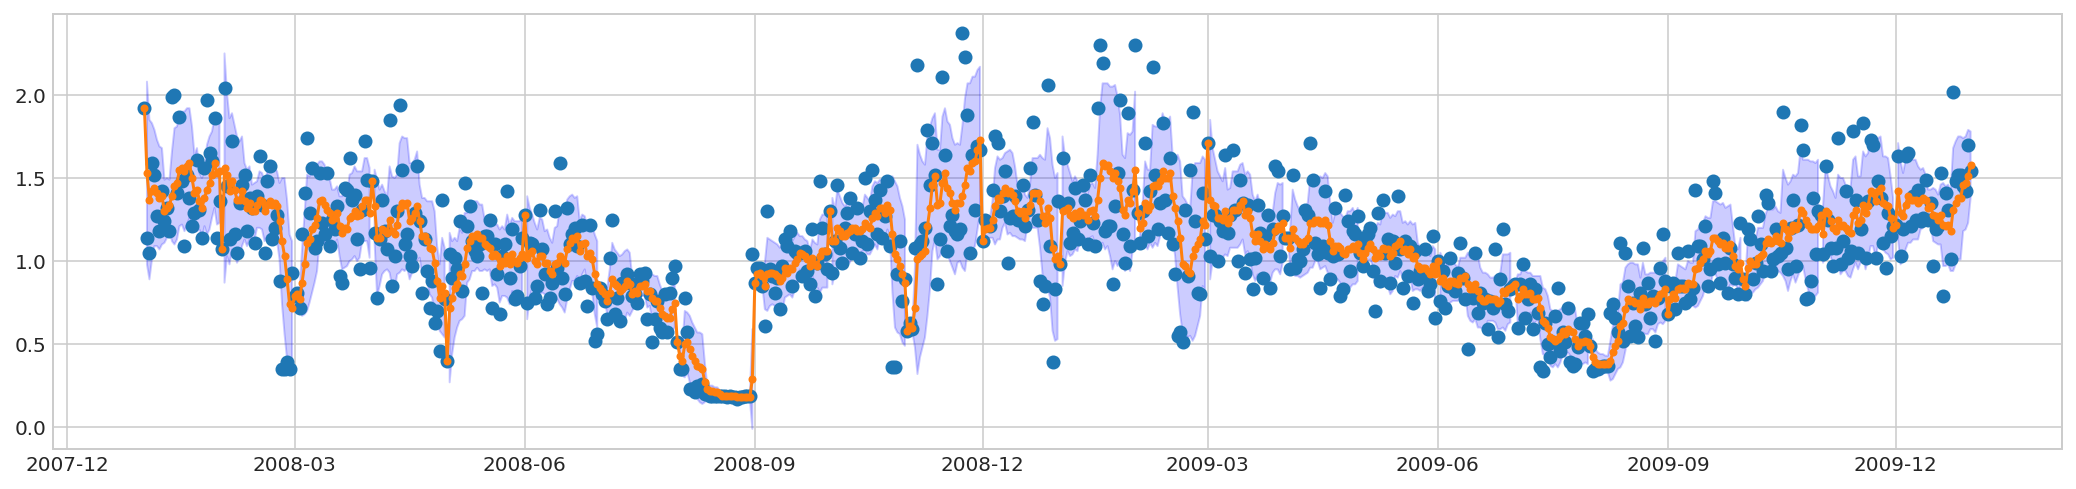

In [49]:
plt.plot_date(pdf.index, pdf['avg_consumption'])
plt.plot_date(pdf.index, pdf['moving_avg'], linestyle='-', marker='.')
plt.fill_between(pdf.index, pdf['moving_avg'] - 1 * pdf['std_dev'], pdf['moving_avg'] + 1 * pdf['std_dev'], color='b', alpha = 0.2);

## 3. Sessionization of a Clickstream
`Sessionization` can be explained as the process of dividing a clickstream into sessions based on key-based partitioning, and within that subdividing based on click frequency. For example, one frequently used mechanism is to consider two clicks from a particular IP address that take place more than 30 minutes apart as being different sessions.

Users' click stream data https://www.kaggle.com/retailrocket/ecommerce-dataset

In [50]:
RETAILROCKET_CLICKSTREAM = 'data/retailrocket-recommender-system-dataset/events.csv'

In [51]:
user_events = spark.read.csv(path=RETAILROCKET_CLICKSTREAM, header=True, inferSchema=True)

In [52]:
user_events.count()

2756101

In [53]:
user_events.sample(withReplacement=False, fraction=0.000005, seed=rnd_seed).limit(10).show()

+-------------+---------+-----+------+-------------+
|    timestamp|visitorid|event|itemid|transactionid|
+-------------+---------+-----+------+-------------+
|1433270143882|   111658| view|109616|         null|
|1433999574695|  1093974| view|418366|         null|
|1434874420982|   193328| view|447074|         null|
|1435466475091|    15149| view|390098|         null|
|1440219866779|  1023568| view| 38404|         null|
|1440706319925|   635259| view|188390|         null|
|1442297965843|  1056782| view|304246|         null|
|1436047155194|  1164077| view|297721|         null|
|1436323207355|   269503| view|142466|         null|
|1438038026270|   721937| view|  5510|         null|
+-------------+---------+-----+------+-------------+



In [54]:
user_events.printSchema()

root
 |-- timestamp: long (nullable = true)
 |-- visitorid: integer (nullable = true)
 |-- event: string (nullable = true)
 |-- itemid: integer (nullable = true)
 |-- transactionid: integer (nullable = true)



It looks like that the timestamp is reeported in milliseconds  
1428476400  
1433221332117

### 3.1. User Events:

In [55]:
user_events = user_events.withColumn('event_time', F.from_unixtime(col('timestamp') / 1000, format='yyyy-MM-dd HH:mm:ss'))

In [56]:
user_events.printSchema()

root
 |-- timestamp: long (nullable = true)
 |-- visitorid: integer (nullable = true)
 |-- event: string (nullable = true)
 |-- itemid: integer (nullable = true)
 |-- transactionid: integer (nullable = true)
 |-- event_time: string (nullable = true)



In [57]:
user_events = user_events.select('timestamp', 'event_time', 'visitorid', 'event', 'itemid', 'transactionid')

In [58]:
user_events.cache().createOrReplaceTempView('user_events')

In [59]:
user_events.limit(10).show()

+-------------+-------------------+---------+-----+------+-------------+
|    timestamp|         event_time|visitorid|event|itemid|transactionid|
+-------------+-------------------+---------+-----+------+-------------+
|1433221332117|2015-06-02 05:02:12|   257597| view|355908|         null|
|1433224214164|2015-06-02 05:50:14|   992329| view|248676|         null|
|1433221999827|2015-06-02 05:13:19|   111016| view|318965|         null|
|1433221955914|2015-06-02 05:12:35|   483717| view|253185|         null|
|1433221337106|2015-06-02 05:02:17|   951259| view|367447|         null|
|1433224086234|2015-06-02 05:48:06|   972639| view| 22556|         null|
|1433221923240|2015-06-02 05:12:03|   810725| view|443030|         null|
|1433223291897|2015-06-02 05:34:51|   794181| view|439202|         null|
|1433220899221|2015-06-02 04:54:59|   824915| view|428805|         null|
|1433221204592|2015-06-02 05:00:04|   339335| view| 82389|         null|
+-------------+-------------------+---------+-----+

What makes this interesting is that the dependency on a session is defined based on the difference between the current timestamp and the previous timestamp, which we can calculate easily using the lag() window function:

In [60]:
spark.sql(
"""
SELECT
    timestamp,
    visitorid,
    event_time,
    LAG(timestamp, 1) OVER (PARTITION BY visitorid ORDER BY timestamp) as prev_timestamp,
    ROUND((timestamp - LAG(timestamp, 1) OVER (PARTITION BY visitorid ORDER BY timestamp)) / (1000 * 60), 2) as inactive_minutes
FROM user_events
ORDER BY visitorid, timestamp
""").show()

+-------------+---------+-------------------+--------------+----------------+
|    timestamp|visitorid|         event_time|prev_timestamp|inactive_minutes|
+-------------+---------+-------------------+--------------+----------------+
|1442004589439|        0|2015-09-11 20:49:49|          null|            null|
|1442004759591|        0|2015-09-11 20:52:39| 1442004589439|            2.84|
|1442004917175|        0|2015-09-11 20:55:17| 1442004759591|            2.63|
|1439487966444|        1|2015-08-13 17:46:06|          null|            null|
|1438969904567|        2|2015-08-07 17:51:44|          null|            null|
|1438970013790|        2|2015-08-07 17:53:33| 1438969904567|            1.82|
|1438970212664|        2|2015-08-07 17:56:52| 1438970013790|            3.31|
|1438970468920|        2|2015-08-07 18:01:08| 1438970212664|            4.27|
|1438970905669|        2|2015-08-07 18:08:25| 1438970468920|            7.28|
|1438971444375|        2|2015-08-07 18:17:24| 1438970905669|    

This gets us partway, but only gives us an indication of when a new session begins. To complete the problem, we need a distinct session number to be generated. This can be done with one extra pass over the result, to add up the new session events as an accumulated sum:

### 3.2. User Sessions:

In [61]:
user_sessions = spark.sql("""
SELECT 
    CONCAT_WS('-', e.visitorid, ROW_NUMBER() OVER (PARTITION BY visitorid ORDER BY timestamp)) as session_id,
    e.visitorid,
    e.timestamp as session_start_timestamp,
    e.event_time as session_start_at,
    LEAD(e.event_time, 1) OVER (PARTITION BY e.visitorid ORDER BY e.timestamp) as next_session_start_at,
    LEAD(e.timestamp, 1) OVER (PARTITION BY e.visitorid ORDER BY e.timestamp) as next_session_start_timestamp
FROM (SELECT 
        visitorid, 
        timestamp,
        event_time, 
        ROUND((timestamp - LAG(timestamp, 1) OVER (PARTITION BY visitorid ORDER BY timestamp)) / (1000 * 60), 2) as inactive_minutes
      FROM user_events)  e
WHERE (e.inactive_minutes > 30 or e.inactive_minutes is null)
ORDER BY e.visitorid, session_start_at
"""
).cache()

user_sessions.createOrReplaceTempView('user_sessions')

In [62]:
spark.sql("SELECT * FROM user_sessions").show(10)

+----------+---------+-----------------------+-------------------+---------------------+----------------------------+
|session_id|visitorid|session_start_timestamp|   session_start_at|next_session_start_at|next_session_start_timestamp|
+----------+---------+-----------------------+-------------------+---------------------+----------------------------+
|       0-1|        0|          1442004589439|2015-09-11 20:49:49|                 null|                        null|
|       1-1|        1|          1439487966444|2015-08-13 17:46:06|                 null|                        null|
|       2-1|        2|          1438969904567|2015-08-07 17:51:44|                 null|                        null|
|       3-1|        3|          1438413035296|2015-08-01 07:10:35|                 null|                        null|
|       4-1|        4|          1442352267167|2015-09-15 21:24:27|                 null|                        null|
|       5-1|        5|          1437097556439|2015-07-17

### 3.3. Session Statistics:

Once we have user_sessions and user_events table, then it's easy to answer user analytics questions such as average session duration.

In [63]:
sessions_stats = spark.sql(
"""
SELECT 
    user_sessions.session_id,
    ROUND(((max(user_events.timestamp) - min(user_events.timestamp)) / (1000 * 60)), 2) as duration_mins
    FROM user_sessions
        LEFT JOIN user_events ON user_events.visitorid = user_sessions.visitorid
    AND user_events.timestamp >= user_sessions.session_start_timestamp
    AND (user_sessions.next_session_start_at is null or user_events.timestamp < next_session_start_timestamp)
    GROUP BY user_sessions.session_id
""").cache()

sessions_stats.createOrReplaceTempView('sessions_stats')

In [64]:
spark.sql("SELECT * FROM sessions_stats").show(10)

+----------+-------------+
|session_id|duration_mins|
+----------+-------------+
|   26425-1|          0.0|
|   30903-4|         49.6|
|   36224-1|          0.0|
|  120861-1|          0.0|
|  124967-1|          0.0|
|  197258-2|          0.0|
|  208696-1|          0.0|
|  226243-1|          0.0|
|  233044-1|          1.3|
|  233567-3|          0.0|
+----------+-------------+
only showing top 10 rows



We can see that most of the durations are zero because we do not have a log out time. We can assume average 15 min duration.

In [65]:
sessions_stats = spark.sql(
"""
SELECT 
    user_sessions.session_id,
    CASE WHEN (max(user_events.timestamp) != min(user_events.timestamp)) THEN ROUND(((max(user_events.timestamp) - min(user_events.timestamp)) / (1000 * 60)), 2) ELSE 15 END as duration_mins
    FROM user_sessions
        LEFT JOIN user_events ON user_events.visitorid = user_sessions.visitorid
    AND user_events.timestamp >= user_sessions.session_start_timestamp
    AND (user_sessions.next_session_start_at is null or user_events.timestamp < next_session_start_timestamp)
    GROUP BY user_sessions.session_id
""").cache()

sessions_stats.createOrReplaceTempView('sessions_stats')

In [66]:
spark.sql("SELECT * FROM sessions_stats").show(10)

+----------+-------------+
|session_id|duration_mins|
+----------+-------------+
|   26425-1|         15.0|
|   30903-4|         49.6|
|   36224-1|         15.0|
|  120861-1|         15.0|
|  124967-1|         15.0|
|  197258-2|         15.0|
|  208696-1|         15.0|
|  226243-1|         15.0|
|  233044-1|          1.3|
|  233567-3|         15.0|
+----------+-------------+
only showing top 10 rows



### 3.4. Event Statistics:

Once we have user_sessions and user_events table, then it's easy to answer events analytics questions such as how many items were viewed in a particular session and how many transactions were done in a particular user session.

In [67]:
user_sessions.printSchema()

root
 |-- session_id: string (nullable = false)
 |-- visitorid: integer (nullable = true)
 |-- session_start_timestamp: long (nullable = true)
 |-- session_start_at: string (nullable = true)
 |-- next_session_start_at: string (nullable = true)
 |-- next_session_start_timestamp: long (nullable = true)



In [68]:
user_events.printSchema()

root
 |-- timestamp: long (nullable = true)
 |-- event_time: string (nullable = true)
 |-- visitorid: integer (nullable = true)
 |-- event: string (nullable = true)
 |-- itemid: integer (nullable = true)
 |-- transactionid: integer (nullable = true)



In [69]:
spark.sql(
"""
SELECT 
    user_sessions.session_id, split(user_sessions.session_id, '-')[1] as visitorid, user_events.event, COUNT(user_events.event)
    FROM user_sessions
        LEFT JOIN user_events ON user_events.visitorid = user_sessions.visitorid
    AND user_events.timestamp >= user_sessions.session_start_timestamp
    AND (user_sessions.next_session_start_at is null or user_events.timestamp < user_sessions.next_session_start_timestamp)
    GROUP BY user_sessions.session_id, user_events.event
""").show(10)

+----------+---------+---------+------------+
|session_id|visitorid|    event|count(event)|
+----------+---------+---------+------------+
|   53634-1|        1|     view|           1|
|   53691-1|        1|     view|           1|
|   85321-1|        1|     view|           2|
|  176895-2|        2|     view|           2|
|  216619-1|        1|     view|           1|
|  242249-2|        2|     view|           1|
|  253765-1|        1|     view|           1|
| 260726-13|       13|     view|           1|
|  285602-1|        1|addtocart|           1|
|  311803-1|        1|     view|           1|
+----------+---------+---------+------------+
only showing top 10 rows



#### 3.4.1. Pivoting on Event Types:

We can pivot the above table on event types so that we can gather the event statistics side by side instead of a columnar fashion for each session.

In [70]:
spark.sql(
"""
SELECT 
    session_id, 
    split(session_id, '-')[1] as visitorid,
    COALESCE(view, 0) as view, 
    COALESCE(addtocart, 0) as addtocart, 
    COALESCE(transaction, 0) as transaction,
    COALESCE(view, 0) + COALESCE(addtocart, 0) + COALESCE(transaction, 0) as total_events
FROM(
    SELECT 
        user_sessions.session_id, user_events.event
    FROM user_sessions
        LEFT JOIN user_events ON user_events.visitorid = user_sessions.visitorid
    AND user_events.timestamp >= user_sessions.session_start_timestamp
    AND (user_sessions.next_session_start_at is null or user_events.timestamp < user_sessions.next_session_start_timestamp)
    )
    PIVOT(
        COUNT(event)
        FOR event in ('view', 'addtocart', 'transaction')
    )
""").cache().createOrReplaceTempView('events_stats')

In [71]:
spark.sql("SELECT * FROM events_stats").show(10)

+----------+---------+----+---------+-----------+------------+
|session_id|visitorid|view|addtocart|transaction|total_events|
+----------+---------+----+---------+-----------+------------+
| 1251630-1|        1|   1|        0|          0|           1|
| 1090982-1|        1|   1|        0|          0|           1|
| 1237309-2|        2|   1|        0|          0|           1|
|  978885-1|        1|   2|        0|          0|           2|
|   42400-1|        1|   1|        0|          0|           1|
| 1124371-1|        1|   1|        0|          0|           1|
|  448936-2|        2|   1|        0|          0|           1|
|  987692-1|        1|   1|        0|          0|           1|
|  175236-1|        1|   1|        0|          0|           1|
|  609069-1|        1|   1|        1|          0|           2|
+----------+---------+----+---------+-----------+------------+
only showing top 10 rows



#### 3.4.2. Users who viewed most in our platform:

In [72]:
spark.sql(
"""
SELECT visitorid, SUM(view) as views 
FROM events_stats
GROUP BY visitorid
ORDER BY views desc
""").show(10)

+---------+-------+
|visitorid|  views|
+---------+-------+
|        1|1981617|
|        2| 297366|
|        3| 104271|
|        4|  51999|
|        5|  31348|
|        6|  21335|
|        7|  15540|
|        8|  11939|
|        9|  10183|
|       10|   8644|
+---------+-------+
only showing top 10 rows



#### 3.4.3. Users who added to cart most in our platform:

In [73]:
spark.sql(
"""
SELECT visitorid, SUM(addtocart) as addtocarts 
FROM events_stats
GROUP BY visitorid
ORDER BY addtocarts desc
""").show(10)

+---------+----------+
|visitorid|addtocarts|
+---------+----------+
|        1|     42012|
|        2|      9904|
|        3|      3819|
|        4|      2095|
|        5|      1269|
|        6|      1167|
|        7|       647|
|        8|       545|
|        9|       476|
|       10|       375|
+---------+----------+
only showing top 10 rows



#### 3.4.4. Users who made most trasactions in our platform:

In [74]:
spark.sql(
"""
SELECT visitorid, SUM(transaction) as transactions 
FROM events_stats
GROUP BY visitorid
ORDER BY transactions desc
""").show(10)

+---------+------------+
|visitorid|transactions|
+---------+------------+
|        1|        9530|
|        2|        3663|
|        3|        1586|
|        4|         921|
|        5|         568|
|        6|         480|
|        7|         380|
|        8|         340|
|        9|         201|
|       12|         194|
+---------+------------+
only showing top 10 rows



## 4. Funnel Analysis of a Clickstream

Funnels are an extremely useful and helpful data tool that can provide US a great overview about our product. In a nutshell, funnels are representing several events your users perform one after another. Calculating how many unique users made each event could show US a conversion rate between each step, so we could actually localize a problem down to a certain stage.

In [75]:
spark.sql(
"""
SELECT 
    user_sessions.session_id, user_events.*
    FROM user_sessions, user_events
    WHERE user_events.visitorid = user_sessions.visitorid
    AND user_events.timestamp >= user_sessions.session_start_timestamp
    AND user_events.event = 'transaction'
""").show()

+----------+-------------+-------------------+---------+-----------+------+-------------+
|session_id|    timestamp|         event_time|visitorid|      event|itemid|transactionid|
+----------+-------------+-------------------+---------+-----------+------+-------------+
|    4101-1|1432168345279|2015-05-21 00:32:25|     4101|transaction|170353|         5362|
|    4101-1|1432168345232|2015-05-21 00:32:25|     4101|transaction|104752|         5362|
|    4101-1|1432168345013|2015-05-21 00:32:25|     4101|transaction|400859|         5362|
|    4101-1|1432168345247|2015-05-21 00:32:25|     4101|transaction|228066|         5362|
|   12046-1|1432397496727|2015-05-23 16:11:36|    12046|transaction|205663|        14286|
|   18024-1|1441225246271|2015-09-02 20:20:46|    18024|transaction|228644|        16297|
|   18024-2|1441225246271|2015-09-02 20:20:46|    18024|transaction|228644|        16297|
|   29744-1|1442241740715|2015-09-14 14:42:20|    29744|transaction| 79056|         3667|
|   29744-

In [76]:
spark.sql(
"""
select * from user_sessions where session_id = '4101-1'
"""
).show()

+----------+---------+-----------------------+-------------------+---------------------+----------------------------+
|session_id|visitorid|session_start_timestamp|   session_start_at|next_session_start_at|next_session_start_timestamp|
+----------+---------+-----------------------+-------------------+---------------------+----------------------------+
|    4101-1|     4101|          1432167078986|2015-05-21 00:11:18|                 null|                        null|
+----------+---------+-----------------------+-------------------+---------------------+----------------------------+



In [77]:
spark.sql(
"""
select * from user_events where visitorid = 4101 and timestamp >= 1432167078986 and timestamp < (1432167078986 + 30 *60 *1000)
"""
).show()

+-------------+-------------------+---------+-----------+------+-------------+
|    timestamp|         event_time|visitorid|      event|itemid|transactionid|
+-------------+-------------------+---------+-----------+------+-------------+
|1432167965863|2015-05-21 00:26:05|     4101|       view|104752|         null|
|1432167910185|2015-05-21 00:25:10|     4101|       view|115244|         null|
|1432167114350|2015-05-21 00:11:54|     4101|       view|115244|         null|
|1432167968276|2015-05-21 00:26:08|     4101|  addtocart|104752|         null|
|1432167929507|2015-05-21 00:25:29|     4101|       view|376365|         null|
|1432167078986|2015-05-21 00:11:18|     4101|       view|320620|         null|
|1432167806833|2015-05-21 00:23:26|     4101|       view|356690|         null|
|1432168094309|2015-05-21 00:28:14|     4101|  addtocart|400859|         null|
|1432168120855|2015-05-21 00:28:40|     4101|       view|400859|         null|
|1432168345279|2015-05-21 00:32:25|     4101|transac

In [78]:
spark.sql(
"""
SELECT session_id, 
CASE WHEN array_contains(events, "view") THEN 1 ELSE 0 END AS funnel_step_view, 
CASE WHEN(array_contains(events, "view") AND array_contains(events, "addtocart")) THEN 1 ELSE 0 END AS funnel_step_addtocart,
CASE WHEN(array_contains(events, "view") AND array_contains(events, "addtocart") AND array_contains(events, "transaction")) THEN 1 ELSE 0 END AS  funnel_step_transaction
FROM( 
    SELECT 
        user_sessions.session_id, COLLECT_SET(user_events.event) AS events
        FROM user_sessions, user_events
        WHERE user_events.visitorid = user_sessions.visitorid
        AND user_events.timestamp >= user_sessions.session_start_timestamp
        AND (user_sessions.next_session_start_at is null or user_events.timestamp < user_sessions.next_session_start_timestamp)
        GROUP BY user_sessions.session_id
    )
""").show(10, truncate=False)

+----------+----------------+---------------------+-----------------------+
|session_id|funnel_step_view|funnel_step_addtocart|funnel_step_transaction|
+----------+----------------+---------------------+-----------------------+
|1000146-1 |1               |0                    |0                      |
|1000256-1 |1               |0                    |0                      |
|1000295-1 |1               |0                    |0                      |
|1000306-95|1               |0                    |0                      |
|1000405-2 |1               |0                    |0                      |
|1000482-1 |1               |0                    |0                      |
|1000501-1 |1               |0                    |0                      |
|1000517-1 |1               |0                    |0                      |
|1000623-1 |1               |0                    |0                      |
|1000913-1 |1               |0                    |0                      |
+----------+

In [79]:
funnel_stats = spark.sql(
"""
SELECT 
    SUM(funnel_step_view) AS total_funnel_step_view, 
    SUM(funnel_step_addtocart) AS total_funnel_step_view, 
    SUM(funnel_step_transaction) AS total_funnel_step_transaction
FROM(
    SELECT session_id, 
    CASE WHEN array_contains(events, "view") THEN 1 ELSE 0 END AS funnel_step_view, 
    CASE WHEN(array_contains(events, "view") AND array_contains(events, "addtocart")) THEN 1 ELSE 0 END AS funnel_step_addtocart,
    CASE WHEN(array_contains(events, "view") AND array_contains(events, "addtocart") AND array_contains(events, "transaction")) THEN 1 ELSE 0 END AS  funnel_step_transaction
    FROM( 
        SELECT 
            user_sessions.session_id, COLLECT_SET(user_events.event) AS events
            FROM user_sessions, user_events
            WHERE user_events.visitorid = user_sessions.visitorid
            AND user_events.timestamp >= user_sessions.session_start_timestamp
            AND (user_sessions.next_session_start_at is null or user_events.timestamp < user_sessions.next_session_start_timestamp)
            GROUP BY user_sessions.session_id
        )
)
""").cache()

In [80]:
funnel_stats.show(10, truncate=False)

+----------------------+----------------------+-----------------------------+
|total_funnel_step_view|total_funnel_step_view|total_funnel_step_transaction|
+----------------------+----------------------+-----------------------------+
|1755771               |38726                 |11143                        |
+----------------------+----------------------+-----------------------------+



In [82]:
spark.stop()

**References:**

There are many blogs and stack overflow question answers that I had consulted along with my own experiments to make this notebok. Each of these blog deserves a Big Thank You!

https://content.pivotal.io/blog/time-series-analysis-1-introduction-to-window-functions  
https://www.dataiku.com/learn/guide/code/reshaping_data/sessionization.html  
https://statsbot.co/blog/event-analytics-define-user-sessions-sql/  
https://stackoverflow.com/questions/33207164/spark-window-functions-rangebetween-dates  
https://blog.statsbot.co/sql-queries-for-funnel-analysis-35d5e456371d  
https://snowplowanalytics.com/blog/2015/05/21/first-experiments-with-apache-spark/  
